## Non Negative Matrix Factorization (NMF) applied to Acapela denoising.

In [1]:
!pip install soundfile
import soundfile as snd
!pip install resampy
import resampy

import os.path
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from STFT import Stft, Istft
from nmf.snmf import BetanmfSparse
from nmf.pgnmf import *

In [2]:
train_file = ''
dirname = './audio'
speechFile = './audio/example.wav'  # noisy file
# output dir
outputDir = './outputandmodel'
# model
model_filename = 'model.npy'
model_file = os.path.join(outputDir, model_filename)

### Process denoising

In [3]:
noise_floor = 1e-10  # small constant in IS nmf
small_const_add_spec = 1e-10  # add this small constant to input spectrogram

load background music model

In [4]:
w_music = np.load(model_file)

read file

In [5]:
y, fs = snd.read(speechFile)
# down to mono channel
if y.ndim > 1:
    y = np.mean(y, axis=1)

# resample if necessary
if fs != 22050:
    print("resampling to 22kHz")
    y = resampy.resample(y, fs, 22050)
    fs = 22050

STFT parameters

In [6]:
# STFT parameters
wlen_millisec = 50  # analysis window length in milliseconds
wlen = int(np.floor(fs * wlen_millisec / 1000.))
print('Window length %d ms, %d samples' % (int(np.floor(wlen_millisec)), wlen))

hlen = wlen // 2
n_fft = 1
while n_fft < wlen:
    n_fft *= 2
print('fft size : %d' % n_fft)


Window length 50 ms, 1102 samples
fft size : 2048


Short Time Fourier Transform (STFT)

In [7]:
# STFT
X, f, t = Stft(y, wlen, hlen, n_fft, fs)
spec = np.abs(X)  # magnitude spectrogram
spec += small_const_add_spec
# F, N = spec.shape
print('running an input matrix of size {}'.format(spec.shape))

running an input matrix of size (1025, 375)


process Non Negative Matrix Factorization (NMF)

In [8]:
# 3) global NMF
Kspeech = 50  # number of speech components
F, N = spec.shape
w_speech = np.abs(np.random.randn(F, Kspeech)) + 1e-8
w_all_init = np.hstack((w_speech, w_music))
w_all = np.copy(w_all_init)
ind_w = range(Kspeech)  # update speech only
# NMF parameters
Beta = 1.
nb_iter = 300
w_all, h_all, v_all, cost = BetanmfSparse(spec, W=w_all, indW=ind_w,Beta=Beta, nbIter=nb_iter,
                                       noiseFloor=noise_floor)

- It 300, cost : 24842.15


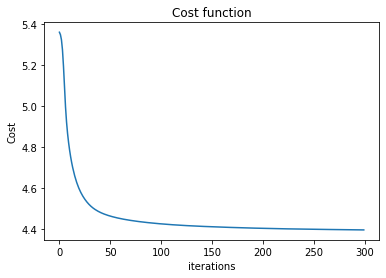

In [9]:
plt.plot(np.log10(cost))
plt.title('Cost function')
plt.xlabel('iterations')
plt.ylabel('Cost')
plt.show()

Wiener filtering and signal reconstruction (inverse STFT)

In [10]:
# 5) Wiener filtering
w_speech_out = w_all[:, ind_w]
h_speech_out = h_all[ind_w, :]
v_speech_out = w_speech_out.dot(h_speech_out) + noise_floor

X_speech = X*v_speech_out/v_all

# 6) inverse STFT
x_speech, _ = Istft(X_speech, wlen, hlen, n_fft, fs)

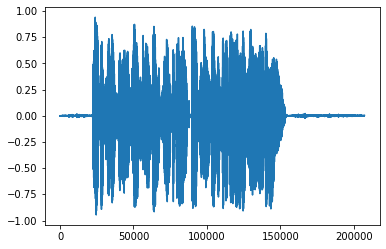

In [11]:
plt.plot(x_speech)
plt.show()

save output file

In [12]:
filename = os.path.basename(speechFile)
outputFile = os.path.join(outputDir, filename[:-4] + 'denoised_ipynb.wav')
snd.write(outputFile, x_speech, fs)

In [13]:
# input audio
ipd.Audio(speechFile)

In [14]:
# denoised audio
ipd.Audio(outputFile)